EJERCICIO 1 - Análisis Exploratorio de Datos

### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import gc

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Analisis de dataset

## Cargar datos

In [2]:
# cargamos desde enero 2025 hasta marzo 2025 datos de yellow trip
dfs = [
     pd.read_parquet('yellow_tripdata_2025-01.parquet'),
     pd.read_parquet('yellow_tripdata_2025-02.parquet'),
     pd.read_parquet('yellow_tripdata_2025-03.parquet')
]

# Concatenar todos los DataFrames optimizados
trips_df_original = pd.concat(dfs, ignore_index=True)

# Limpiar inmediatamente la lista y forzar al garbage collector si es necesario
del dfs
gc.collect()

0

In [3]:
# cargamos las zonas de los taxis
locations = pd.read_csv('taxi_zone_lookup.csv')

In [4]:
# joineamos las zonas de los taxis con nuestros viajes
df = trips_df_original.merge(
  locations.add_suffix('_start'), "left", left_on="PULocationID", right_on="LocationID_start"
)
df = df.merge(
  locations.add_suffix('_end'), "left", left_on="DOLocationID", right_on="LocationID_end"
)

del locations
del trips_df_original

# Exploración inicial


Objetivo: entender tamaño, tipos, y distribución básica.
* info() para dtypes y memoria.
* Conteo de filas y chequeo rápido de montos.
* Distinción cuantitativas vs cualitativas para anticipar tratamiento.

In [5]:
print(df.info(show_counts=True))
print("\nFilas totales:", len(df))
print("\nMonto total estimado:", float(df["total_amount"].abs().sum()))

quantitativas = [
    "tpep_pickup_datetime","tpep_dropoff_datetime",
    "passenger_count","trip_distance",
    "fare_amount","extra","mta_tax","tip_amount","tolls_amount",
    "improvement_surcharge","total_amount","congestion_surcharge",
    "Airport_fee","cbd_congestion_fee"
]
cualitativas = ["PULocationID","DOLocationID","payment_type","RatecodeID"]

print("\nCuantitativas:", quantitativas)
print("Cualitativas:", cualitativas)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11198026 entries, 0 to 11198025
Data columns (total 28 columns):
 #   Column                 Non-Null Count     Dtype         
---  ------                 --------------     -----         
 0   VendorID               11198026 non-null  int32         
 1   tpep_pickup_datetime   11198026 non-null  datetime64[us]
 2   tpep_dropoff_datetime  11198026 non-null  datetime64[us]
 3   passenger_count        8934277 non-null   float64       
 4   trip_distance          11198026 non-null  float64       
 5   RatecodeID             8934277 non-null   float64       
 6   store_and_fwd_flag     8934277 non-null   object        
 7   PULocationID           11198026 non-null  int32         
 8   DOLocationID           11198026 non-null  int32         
 9   payment_type           11198026 non-null  int64         
 10  fare_amount            11198026 non-null  float64       
 11  extra                  11198026 non-null  float64       
 12  mta_tax     

# Analisis de datos faltantes

Calculamos el % de nulos por columna para decidir:
* Imputación simple cuando la regla está clara.
* Completar con 0 cuando el cargo no corresponde (ej.: Airport_fee si no es aeropuerto).
* Eliminar sólo si el registro es inconsistente.

,0
passenger_count,20.215608
RatecodeID,20.215608
store_and_fwd_flag,20.215608
Airport_fee,20.215608
congestion_surcharge,20.215608
service_zone_end,0.620976
Borough_end,0.333434
Zone_end,0.287542
service_zone_start,0.244606
Zone_start,0.208055


/tmp/ipython-input-3429790230.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=na_percent.values[:15], y=na_percent.index[:15], palette="viridis")


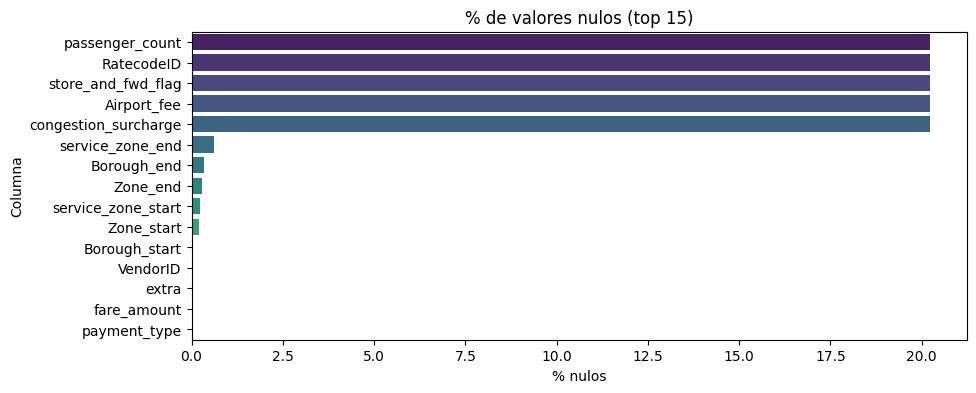

In [6]:
na_percent = (df.isna().sum() / len(df) * 100).sort_values(ascending=False)
display(na_percent.head(15))

plt.figure(figsize=(10,4))
sns.barplot(x=na_percent.values[:15], y=na_percent.index[:15], palette="viridis")
plt.title("% de valores nulos (top 15)")
plt.xlabel("% nulos"); plt.ylabel("Columna")
plt.show()

# Tratamiento de valores atipicos y errores (reglas de negocio)

Aplicamos reglas inspiradas en el Data Dictionary de TLC y tarifas oficiales:
* Tiempos: dropoff > pickup y dentro del rango de meses analizado.
* Pasajeros: válido entre 1 y 6; 0/NaN → moda.
* Montos: negatividad → absoluto; mínimos legales (ej.: fare_amount ≥ 3) y caps conocidos (mta_tax ∈ {0, 0.5}, improvement_surcharge ∈ {0,1}, congestion_surcharge ∈ {0,2.5}, cbd_congestion_fee ≤ 2.5).
* Propina: si payment_type != 1 (no tarjeta) y tip_amount > 0, el registro es inconsistente → eliminar.
* Distancia = 0: imputamos con velocidad promedio de casos válidos: dist = speed_avg * tiempo(h).
* Todas las transformaciones se hacen in-place o con índices para evitar copias grandes.

In [7]:
MONTHS   = ["2025-01","2025-02","2025-03"]

# ---- Downcast seguro para ahorrar RAM (manejo de NaN) ----
# Floats 64 -> 32
for c in df.select_dtypes("float64"):
    df[c] = pd.to_numeric(df[c], errors="coerce").astype("float32")

# Ints 64 -> 32 (sin NaN)
for c in df.select_dtypes("int64"):
    # si no hay NaN, podemos castear directo
    if not df[c].isna().any():
        df[c] = df[c].astype("int32")
    else:
        df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int32")  # entero “nullable”

# Columnas categóricas/IDs que a veces vienen con NaN
for c in ["PULocationID", "DOLocationID", "payment_type", "RatecodeID"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int32")  # permite NaN



# ---- Tiempos válidos ----
mask_bad_time = df["tpep_dropoff_datetime"] <= df["tpep_pickup_datetime"]
df = df.loc[~mask_bad_time]
del mask_bad_time

# Limite de meses (seguridad)
min_date = pd.to_datetime(MONTHS[0] + "-01")
max_date = (pd.to_datetime(MONTHS[-1] + "-01") + pd.offsets.MonthEnd(1) + pd.Timedelta(days=1))
df = df[(df["tpep_pickup_datetime"] >= min_date) & (df["tpep_pickup_datetime"] < max_date)]

# ---- Pasajeros: 1..6 | 0/NaN -> moda ----
mode_pc = df["passenger_count"].dropna().mode()
if len(mode_pc):
    df.loc[df["passenger_count"].isna() | (df["passenger_count"] == 0), "passenger_count"] = mode_pc.iloc[0]
df = df[df["passenger_count"].between(1,6)]

# ---- Montos: hacer positivos cuando tenga sentido ----
for c in ["total_amount","fare_amount","tip_amount","tolls_amount","extra","mta_tax",
          "improvement_surcharge","congestion_surcharge","Airport_fee","cbd_congestion_fee"]:
    if c in df.columns:
        neg = df[c] < 0
        if neg.any():
            df.loc[neg, c] = df.loc[neg, c].abs()

# ---- Mínimos / valores fijos conocidos ----
df = df[df["fare_amount"] >= 3]  # base fare mínimo
df.loc[~df["mta_tax"].isin([0,0.5]), "mta_tax"] = 0.5
df.loc[~df["improvement_surcharge"].isin([0,1]), "improvement_surcharge"] = 1
df.loc[~df["congestion_surcharge"].isin([0,2.5]), "congestion_surcharge"] = 2.5
df.loc[df["cbd_congestion_fee"] > 2.5, "cbd_congestion_fee"] = 2.5
# Fee CBD antes del 5/1/2025 = 0 (si existiera)
mask_cbd_before = (df["tpep_pickup_datetime"] < pd.to_datetime("2025-01-05")) & (df["cbd_congestion_fee"] > 0)
df.loc[mask_cbd_before, "cbd_congestion_fee"] = 0

# ---- Tip con medios que no son tarjeta: inconsistencia -> eliminar ----
mask_bad_tip = (df["tip_amount"] > 0) & (df["payment_type"] != 1)
df = df.loc[~mask_bad_tip]

# ---- Duración y velocidad ----
df["ride_length"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds()/60
df = df[df["ride_length"] > 0]

# Imputación de distancia = 0 con velocidad promedio de válidos
mask_pos = df["trip_distance"] > 0
if mask_pos.any():
    avg_speed = (df.loc[mask_pos,"trip_distance"] / (df.loc[mask_pos,"ride_length"]/60)).mean()
    df.loc[~mask_pos, "trip_distance"] = (df.loc[~mask_pos, "ride_length"]/60) * avg_speed
    del avg_speed
del mask_pos

gc.collect()
print("Shape tras limpieza:", df.shape)


Shape tras limpieza: (10917718, 29)


/tmp/ipython-input-4217749928.py:69: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.06747992  0.05398394 12.88866491 ...  0.53983937  0.18219579
  0.08097591]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.loc[~mask_pos, "trip_distance"] = (df.loc[~mask_pos, "ride_length"]/60) * avg_speed


# Normalización y consistencia

Recalculamos total_amount como suma de componentes ya normalizados, para garantizar coherencia y evitar valores residuales de etapas previas.

In [8]:
components = ["fare_amount","extra","mta_tax","tip_amount","tolls_amount",
              "improvement_surcharge","congestion_surcharge","Airport_fee","cbd_congestion_fee"]
present = [c for c in components if c in df.columns]
df["total_amount"] = df[present].sum(axis=1).astype("float32")

print("Chequeo total_amount (min/mean/p95/max):")
display(df["total_amount"].describe(percentiles=[.5,.9,.95,.99]))


Chequeo total_amount (min/mean/p95/max):


,total_amount
count,1.091772e+07
mean,2.734342e+01
std,2.649489e+02
min,3.000000e+00
50%,2.106000e+01
90%,4.740000e+01
95%,7.475000e+01
99%,1.038300e+02
max,8.633821e+05


# Creacion de nuevas variables

Generamos atributos derivados para responder las preguntas:
* pickup_hour, pickup_dayofweek, part_of_day (franjas: madrugada/mañana/tarde/noche).
* speed_mph = trip_distance / (ride_length/60).


In [9]:
# --- Garantizar columnas temporales clave, sin asumir orden previo ---
if "ride_length" not in df.columns:
    df["ride_length"] = (pd.to_datetime(df["tpep_dropoff_datetime"])
                         - pd.to_datetime(df["tpep_pickup_datetime"])
                        ).dt.total_seconds() / 60.0

# filtrar duraciones inválidas (evita divisiones por 0/negativos)
df = df[df["ride_length"] > 0]

# trip_distance a numérico seguro
df["trip_distance"] = pd.to_numeric(df["trip_distance"], errors="coerce").astype("float32")

# velocidad (mph)
df["speed_mph"] = (df["trip_distance"] / (df["ride_length"] / 60.0)).astype("float32")


# Hora y día
df["pickup_hour"]      = df["tpep_pickup_datetime"].dt.hour.astype("int16")
df["pickup_dayofweek"] = df["tpep_pickup_datetime"].dt.dayofweek.astype("int8")

# Franja horaria categórica ordenada
part_of_day_times = [0,6,12,18,24]
part_of_day_names = ["Madrugada [0-6)","Mañana [6-12)","Tarde [12-18)","Noche [18-24)"]
df["part_of_day"] = pd.cut(
    df["pickup_hour"],
    bins=part_of_day_times,
    labels=part_of_day_names,
    right=False,
    include_lowest=True,
).astype("category")

# Velocidad promedio (mph)
df["speed_mph"] = (df["trip_distance"] / (df["ride_length"]/60)).astype("float32")

# Tip rate (para P3) — solo tarjeta; se calcula más adelante en análisis de propinas
# Acá dejamos preparado el subtotal 'tippeable' para eficientar luego:
base_cols = ["fare_amount","extra","improvement_surcharge","congestion_surcharge","mta_tax"]
if "Airport_fee" in df.columns:
    base_cols.append("Airport_fee")
df["fare_subtotal"] = df[base_cols].sum(axis=1).astype("float32")

gc.collect()
df[["pickup_hour","pickup_dayofweek","part_of_day","ride_length","speed_mph"]].head()


,pickup_hour,pickup_dayofweek,part_of_day,ride_length,speed_mph
0,0,2,Madrugada [0-6),8.350000,11.497006
1,0,2,Madrugada [0-6),2.550000,11.764706
2,0,2,Madrugada [0-6),1.950000,18.461538
3,0,2,Madrugada [0-6),5.566667,5.604790
4,0,2,Madrugada [0-6),3.533333,11.207547


# ¿Cómo varían la distancia y duración por hora y día de semana?

Objetivo: detectar patrones temporales (madrugada/mañana/tarde/noche) a lo largo de la semana.
Métricas: promedios de trip_distance (millas), ride_length (min) y total_amount (USD).
Por qué heatmap: permite comparar rápidamente niveles relativos en una matriz tiempo×tiempo.
Notas de robustez: usamos promedios porque el volumen grande “suaviza”; si hubiera mucha asimetría, podríamos reemplazar por mediana.

## Codigo

/tmp/ipython-input-814892790.py:7: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df["part_of_day"]):


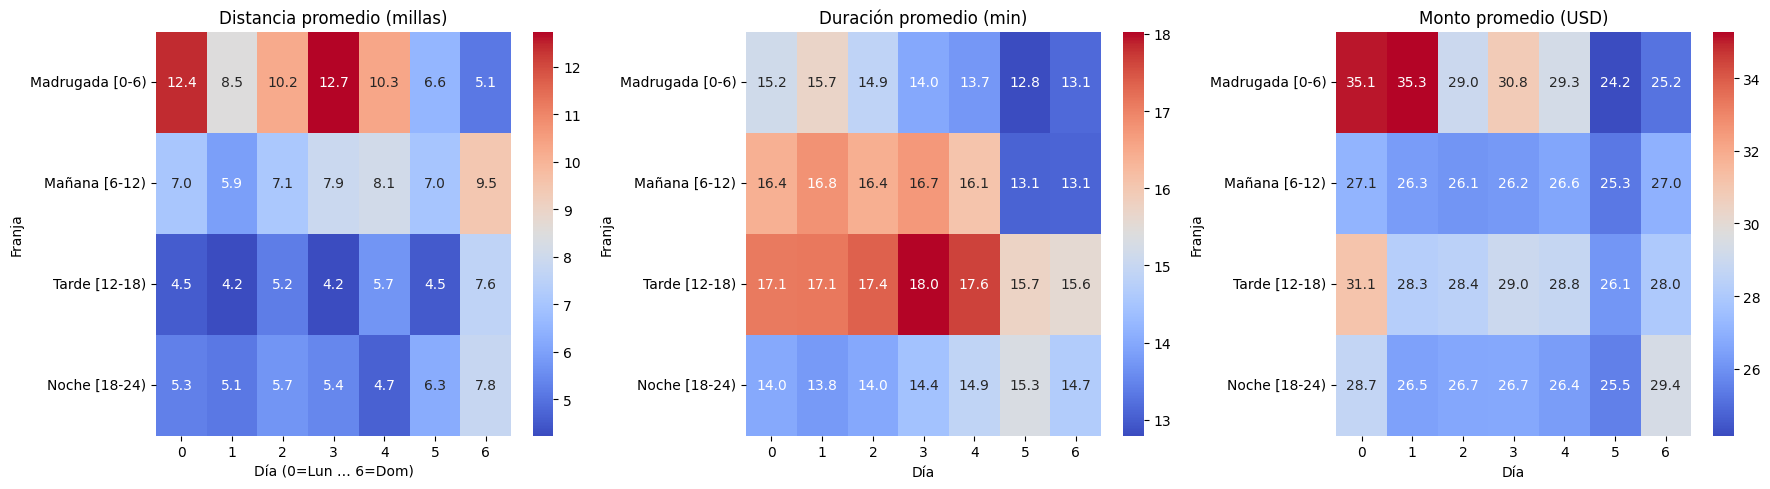

In [10]:
# --- columnas mínimas y garantías suaves (no reescribe df completo) ---
need = ["trip_distance","ride_length","total_amount","pickup_dayofweek","part_of_day"]
missing = [c for c in need if c not in df.columns]
assert not missing, f"Faltan columnas para P1: {missing}"

# Aseguramos dtype 'category' para ejes discretos (agrupa y pivotea más barato)
if not pd.api.types.is_categorical_dtype(df["part_of_day"]):
    part_of_day_names = ["Madrugada [0-6)","Mañana [6-12)","Tarde [12-18)","Noche [18-24)"]
    df["part_of_day"] = pd.Categorical(df["part_of_day"], categories=part_of_day_names, ordered=True)

# Agrupación compacta
g = (df.groupby(["pickup_dayofweek","part_of_day"], observed=True)
        .agg(avg_distance=("trip_distance","mean"),
             avg_duration=("ride_length","mean"),
             avg_amount  =("total_amount","mean"))
        .reset_index())

piv_d = g.pivot(index="part_of_day", columns="pickup_dayofweek", values="avg_distance")
piv_t = g.pivot(index="part_of_day", columns="pickup_dayofweek", values="avg_duration")
piv_m = g.pivot(index="part_of_day", columns="pickup_dayofweek", values="avg_amount")

plt.figure(figsize=(18,5))
plt.subplot(1,3,1); sns.heatmap(piv_d, annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Distancia promedio (millas)"); plt.xlabel("Día (0=Lun … 6=Dom)"); plt.ylabel("Franja")
plt.subplot(1,3,2); sns.heatmap(piv_t, annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Duración promedio (min)"); plt.xlabel("Día"); plt.ylabel("Franja")
plt.subplot(1,3,3); sns.heatmap(piv_m, annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Monto promedio (USD)"); plt.xlabel("Día"); plt.ylabel("Franja")
plt.tight_layout(); plt.show()

del g, piv_d, piv_t, piv_m; gc.collect();

# ¿La velocidad promedio cae en horas pico?

Hipótesis: la velocidad baja cuando sube el volumen (horas pico).
Métrica robusta: usamos mediana de speed_mph para evitar la influencia de outliers (viajes raros o errores).

## Codigo

/tmp/ipython-input-3486773000.py:6: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df["part_of_day"]):


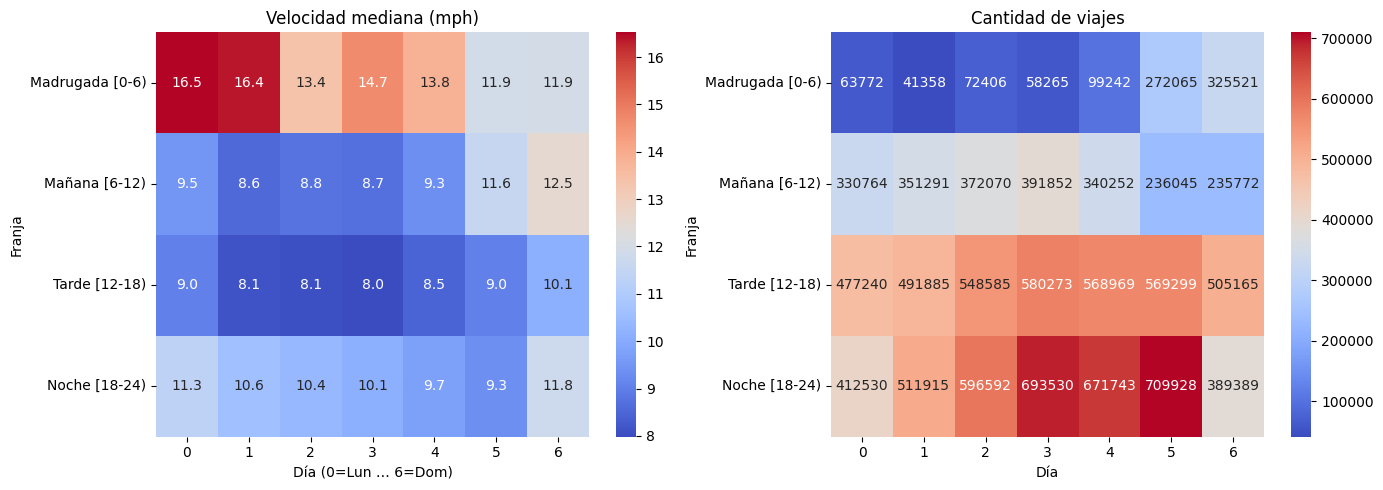

In [11]:
need = ["speed_mph","pickup_dayofweek","part_of_day"]
missing = [c for c in need if c not in df.columns]
assert not missing, f"Faltan columnas para P2: {missing}"

# Aseguramos categoría ordenada para filas
if not pd.api.types.is_categorical_dtype(df["part_of_day"]):
    part_of_day_names = ["Madrugada [0-6)","Mañana [6-12)","Tarde [12-18)","Noche [18-24)"]
    df["part_of_day"] = pd.Categorical(df["part_of_day"], categories=part_of_day_names, ordered=True)
else:
    part_of_day_names = list(df["part_of_day"].cat.categories)

g = (df.groupby(["part_of_day","pickup_dayofweek"], observed=True)
       .agg(med_speed=("speed_mph","median"),
            count    =("speed_mph","size"))
       .reset_index())

mat_med = g.pivot(index="part_of_day", columns="pickup_dayofweek", values="med_speed").reindex(index=part_of_day_names)
mat_cnt = g.pivot(index="part_of_day", columns="pickup_dayofweek", values="count").reindex(index=part_of_day_names)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1); sns.heatmap(mat_med, annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Velocidad mediana (mph)"); plt.xlabel("Día (0=Lun … 6=Dom)"); plt.ylabel("Franja")
plt.subplot(1,2,2); sns.heatmap(mat_cnt, annot=True, fmt=".0f", cmap="coolwarm")
plt.title("Cantidad de viajes"); plt.xlabel("Día"); plt.ylabel("Franja")
plt.tight_layout(); plt.show()


# ¿Qué factores se asocian con mayor tip_rate?

Filtro: solo tarjeta (payment_type==1), porque las propinas en efectivo no se registran.
Factores: distancia (bins), duración (bins), aeropuerto (sí/no), cambio de zona (sí/no), cantidad de pasajeros.

## Codigo


In [12]:
# columnas mínimas
need = ["payment_type","tip_amount","fare_subtotal","trip_distance","ride_length",
        "PULocationID","DOLocationID","RatecodeID","passenger_count","tpep_pickup_datetime"]
missing = [c for c in need if c not in df.columns]
assert not missing, f"Faltan columnas para P3: {missing}"

# Vista mínima para análisis (evitamos copiar todo df)
base_cols = ["payment_type","tip_amount","fare_subtotal","trip_distance","ride_length",
             "PULocationID","DOLocationID","RatecodeID","passenger_count","tpep_pickup_datetime"]
base = df.loc[df["payment_type"]==1, base_cols].dropna(subset=["fare_subtotal","tip_amount"])

# tip_rate con límites razonables
tip_rate = (base["tip_amount"] / base["fare_subtotal"]).clip(0, 0.5)
base = base.assign(tip_rate=tip_rate).loc[lambda x: (x["ride_length"]>0) & (x["trip_distance"]>0)]

# Binning de distancia y duración
dist_bins = [0,1,2,5,10,20,np.inf]; dist_lbls = ['≤1','1–2','2–5','5–10','10–20','>20']
dur_bins  = [0,5,10,15,30,45,60,np.inf]; dur_lbls  = ['≤5','5–10','10–15','15–30','30–45','45–60','>60']

base = base.assign(
    dist_bin = pd.cut(base["trip_distance"], dist_bins, labels=dist_lbls, right=True),
    dur_bin  = pd.cut(base["ride_length"],  dur_bins,  labels=dur_lbls,  right=True),
    is_airport = (base.get("Airport_fee", 0) > 0) | base["RatecodeID"].isin([2,3]),
    zone_change = base["PULocationID"] != base["DOLocationID"],
    passengers = pd.to_numeric(base["passenger_count"], errors="coerce")
)
base = base[(base["passengers"]>=1) & (base["passengers"]<=6)]

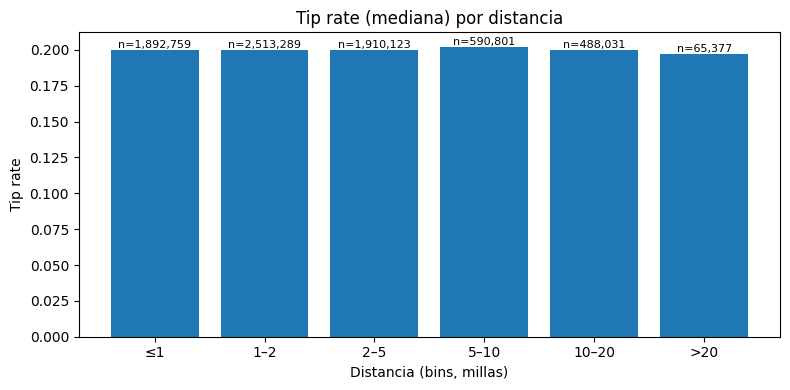

In [13]:
# ---- (a) Tip vs distancia ----
tip_by_dist = (base.groupby("dist_bin", observed=True)["tip_rate"]
                 .agg(tip_med="median", n="size").reset_index())
plt.figure(figsize=(8,4))
plt.bar(tip_by_dist["dist_bin"].astype(str), tip_by_dist["tip_med"].to_numpy())
for i,(y,n) in enumerate(zip(tip_by_dist["tip_med"], tip_by_dist["n"])):
    plt.text(i, y, f"n={n:,}", ha="center", va="bottom", fontsize=8)
plt.title("Tip rate (mediana) por distancia"); plt.xlabel("Distancia (bins, millas)"); plt.ylabel("Tip rate"); plt.tight_layout(); plt.show()

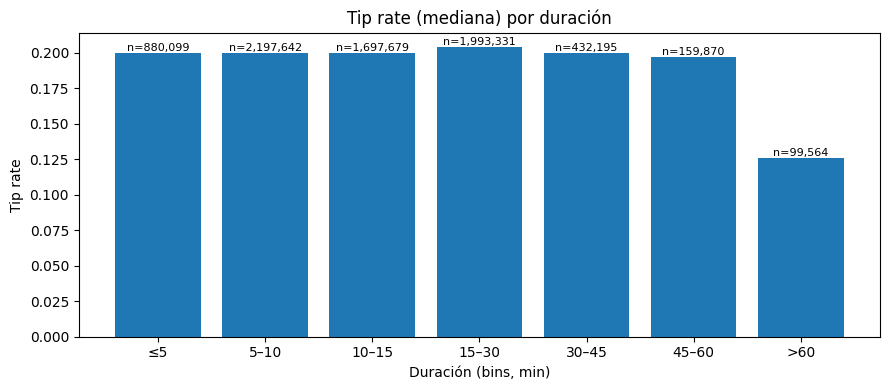

In [14]:
# ---- (b) Tip vs duración ----
tip_by_dur = (base.groupby("dur_bin", observed=True)["tip_rate"]
                .agg(tip_med="median", n="size").reset_index())
plt.figure(figsize=(9,4))
plt.bar(tip_by_dur["dur_bin"].astype(str), tip_by_dur["tip_med"].to_numpy())
for i,(y,n) in enumerate(zip(tip_by_dur["tip_med"], tip_by_dur["n"])):
    plt.text(i, y, f"n={n:,}", ha="center", va="bottom", fontsize=8)
plt.title("Tip rate (mediana) por duración"); plt.xlabel("Duración (bins, min)"); plt.ylabel("Tip rate"); plt.tight_layout(); plt.show()

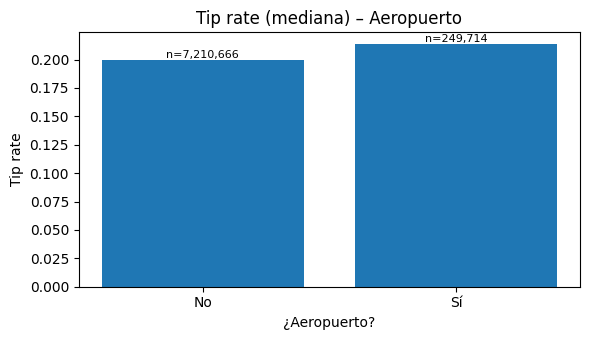

In [15]:
# ---- (c) Aeropuerto (Sí/No) ----
tip_airport = (base.groupby("is_airport", observed=True)["tip_rate"]
                 .agg(tip_med="median", n="size").reset_index())
plt.figure(figsize=(6,3.5))
plt.bar(tip_airport["is_airport"].map({False:"No", True:"Sí"}), tip_airport["tip_med"].to_numpy())
for i,(y,n) in enumerate(zip(tip_airport["tip_med"], tip_airport["n"])):
    plt.text(i, y, f"n={n:,}", ha="center", va="bottom", fontsize=8)
plt.title("Tip rate (mediana) – Aeropuerto"); plt.xlabel("¿Aeropuerto?"); plt.ylabel("Tip rate"); plt.tight_layout(); plt.show()

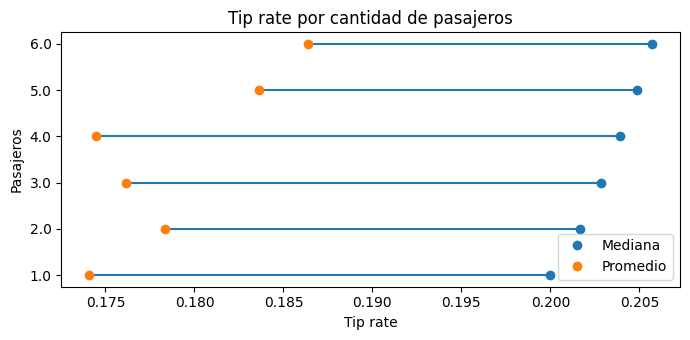

In [16]:
# ---- (d) Pasajeros: mediana vs promedio (líneas entre puntos) ----
tip_pass = (base.groupby("passengers", observed=True)["tip_rate"]
              .agg(tip_med="median", tip_mean="mean", n="size").reset_index())
ys = np.arange(len(tip_pass))
plt.figure(figsize=(7,3.5))
plt.hlines(ys, tip_pass["tip_med"].to_numpy(), tip_pass["tip_mean"].to_numpy())
plt.plot(tip_pass["tip_med"].to_numpy(), ys, "o", label="Mediana")
plt.plot(tip_pass["tip_mean"].to_numpy(), ys, "o", label="Promedio")
plt.yticks(ys, tip_pass["passengers"].to_numpy())
plt.xlabel("Tip rate"); plt.ylabel("Pasajeros"); plt.title("Tip rate por cantidad de pasajeros")
plt.legend(loc="lower right"); plt.tight_layout(); plt.show()

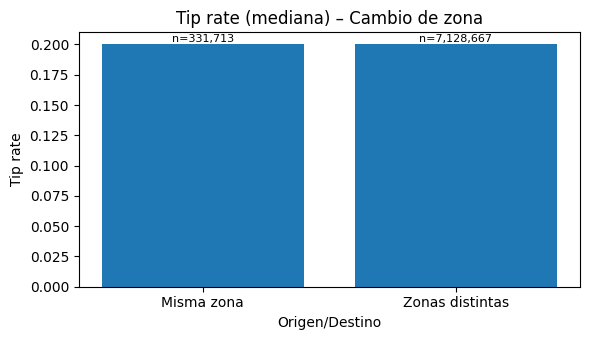

In [17]:
# ---- (e) Cambio de zona (Sí/No) ----
tip_zone = (base.groupby("zone_change", observed=True)["tip_rate"]
              .agg(tip_med="median", n="size").reset_index())
plt.figure(figsize=(6,3.5))
plt.bar(tip_zone["zone_change"].map({False:"Misma zona", True:"Zonas distintas"}), tip_zone["tip_med"].to_numpy())
for i,(y,n) in enumerate(zip(tip_zone["tip_med"], tip_zone["n"])):
    plt.text(i, y, f"n={n:,}", ha="center", va="bottom", fontsize=8)
plt.title("Tip rate (mediana) – Cambio de zona"); plt.xlabel("Origen/Destino"); plt.ylabel("Tip rate"); plt.tight_layout(); plt.show()

# ¿Qué zonas origen/destino concentran viajes largos?

## Codigo

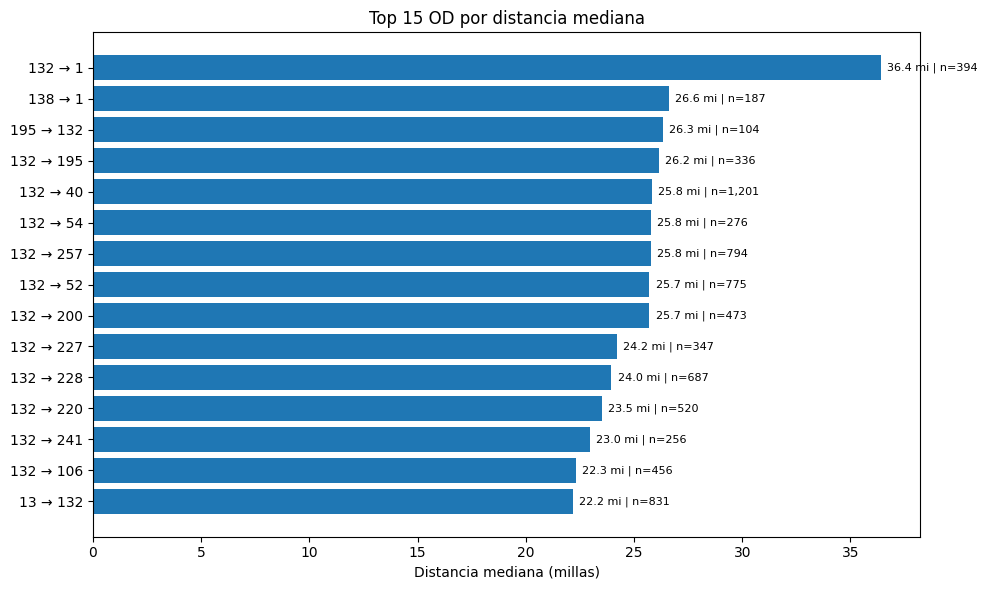

In [18]:
need = ["trip_distance","PULocationID","DOLocationID"]
missing = [c for c in need if c not in df.columns]
assert not missing, f"Faltan columnas para P4: {missing}"

d = df.loc[df["trip_distance"]>0, ["trip_distance","PULocationID","DOLocationID"]]

MIN_N = 100
LONG_THR = 10.0

# (a) Top–15 OD por mediana
od = (d.groupby(["PULocationID","DOLocationID"], observed=True)["trip_distance"]
        .agg(med_distance="median", n="size").reset_index())
od = od[od["n"]>=MIN_N]
od_top = od.nlargest(15, "med_distance")

plt.figure(figsize=(10,6))
labels = [f"{o} → {dd}" for o,dd in zip(od_top["PULocationID"].astype(str), od_top["DOLocationID"].astype(str))]
plt.barh(labels, od_top["med_distance"].to_numpy()); plt.gca().invert_yaxis()
for y,(v,n) in enumerate(zip(od_top["med_distance"], od_top["n"])):
    plt.text(v+0.3, y, f"{v:.1f} mi | n={n:,}", va="center", fontsize=8)
plt.xlabel("Distancia mediana (millas)"); plt.title("Top 15 OD por distancia mediana")
plt.tight_layout(); plt.show()

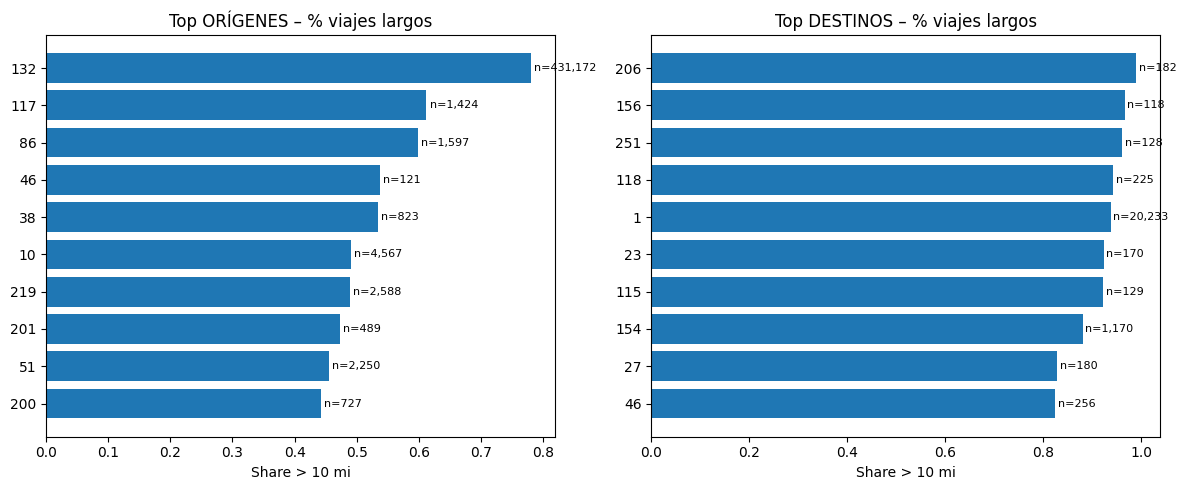

In [19]:
# (b) Orígenes/Destinos con mayor % de viajes largos (>10 mi)
d = d.assign(is_long = d["trip_distance"]>LONG_THR)
orig_long = (d.groupby("PULocationID", observed=True)["is_long"].agg(share_long="mean", n="size").reset_index())
dest_long = (d.groupby("DOLocationID", observed=True)["is_long"].agg(share_long="mean", n="size").reset_index())
orig_long = orig_long[orig_long["n"]>=MIN_N].nlargest(10, "share_long")
dest_long = dest_long[dest_long["n"]>=MIN_N].nlargest(10, "share_long")

fig, axes = plt.subplots(1,2, figsize=(12,5))
axes[0].barh(orig_long["PULocationID"].astype(str).to_numpy(), orig_long["share_long"].to_numpy())
axes[0].invert_yaxis(); axes[0].set_xlabel("Share > 10 mi"); axes[0].set_title("Top ORÍGENES – % viajes largos")
for y,(v,n) in enumerate(zip(orig_long["share_long"], orig_long["n"])):
    axes[0].text(v+0.005, y, f"n={n:,}", va="center", fontsize=8)

axes[1].barh(dest_long["DOLocationID"].astype(str).to_numpy(), dest_long["share_long"].to_numpy())
axes[1].invert_yaxis(); axes[1].set_xlabel("Share > 10 mi"); axes[1].set_title("Top DESTINOS – % viajes largos")
for y,(v,n) in enumerate(zip(dest_long["share_long"], dest_long["n"])):
    axes[1].text(v+0.005, y, f"n={n:,}", va="center", fontsize=8)

plt.tight_layout(); plt.show()

# ¿Las distancias más largas se realizan en viajes en solitario o con 2+ pasajeros?

## Codigo

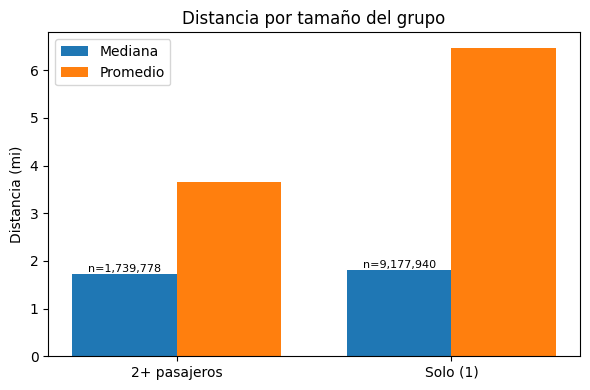

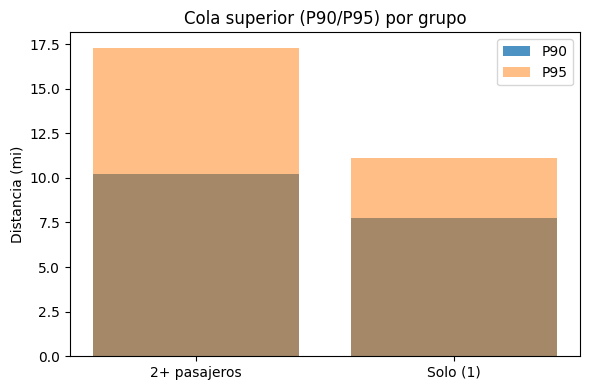

In [20]:
need = ["trip_distance","passenger_count"]
missing = [c for c in need if c not in df.columns]
assert not missing, f"Faltan columnas para P5: {missing}"

d = df.loc[df["trip_distance"]>0, ["trip_distance","passenger_count"]].copy()
d["passenger_count"] = pd.to_numeric(d["passenger_count"], errors="coerce")
d = d[(d["passenger_count"]>=1) & (d["passenger_count"]<=6)]
d["party"] = np.where(d["passenger_count"]==1, "Solo (1)", "2+ pasajeros")

g = (d.groupby("party", observed=True)["trip_distance"]
       .agg(med_distance="median", mean_distance="mean",
            p90=lambda s:s.quantile(0.90),
            p95=lambda s:s.quantile(0.95),
            n="size")
       .reset_index()
       .sort_values("party"))

# (a) Barras: mediana vs promedio
fig, ax = plt.subplots(figsize=(6,4))
x = np.arange(len(g)); w = 0.38
ax.bar(x-w/2, g["med_distance"].to_numpy(), width=w, label="Mediana")
ax.bar(x+w/2, g["mean_distance"].to_numpy(), width=w, label="Promedio")
ax.set_xticks(x); ax.set_xticklabels(g["party"].to_numpy()); ax.set_ylabel("Distancia (mi)")
ax.set_title("Distancia por tamaño del grupo"); ax.legend()
for xi, md, n in zip(x, g["med_distance"], g["n"]):
    ax.text(xi-w/2, md, f"n={n:,}", ha="center", va="bottom", fontsize=8)
plt.tight_layout(); plt.show()


# (b) Colas: P90/P95
plt.figure(figsize=(6,4))
plt.bar(g["party"].to_numpy(), g["p90"].to_numpy(), alpha=.8, label="P90")
plt.bar(g["party"].to_numpy(), g["p95"].to_numpy(), alpha=.5, label="P95")
plt.ylabel("Distancia (mi)"); plt.title("Cola superior (P90/P95) por grupo"); plt.legend()
plt.tight_layout(); plt.show()


# ¿El lugar de origen/ destion del viaje influye en la probabilidad de que el pasajero deje propina?

Miramos el peso relativo de cada zona entre viajes con propina (tarjeta) para ver si ciertas áreas están sobrerrepresentadas.

## Codigo

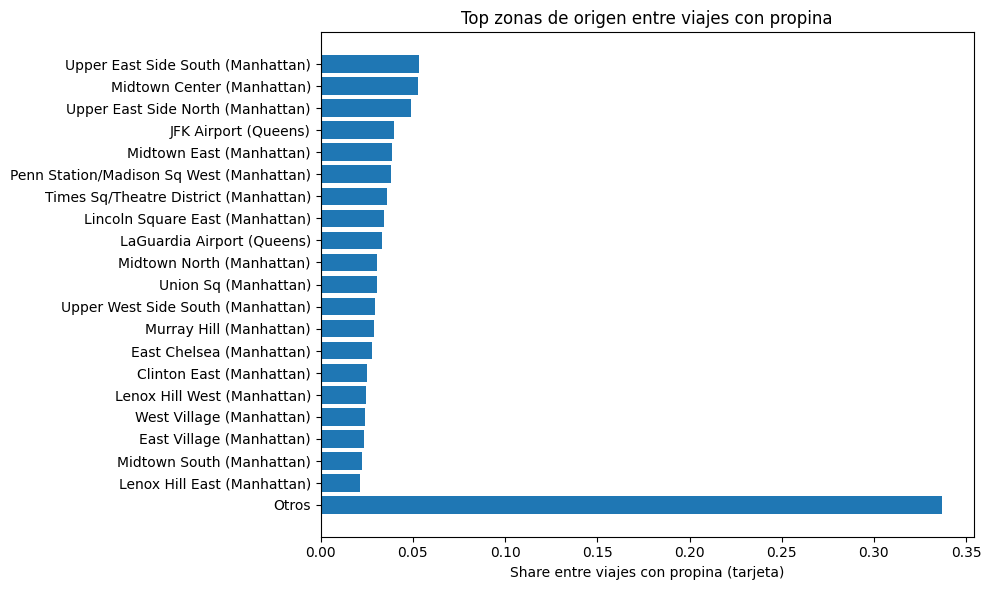

In [21]:
# columnas posibles (por merge previo de zones)
bor_col = "Borough_start" if "Borough_start" in df.columns else None
zon_col = "Zone_start" if "Zone_start" in df.columns else None
use_label = None

if bor_col and zon_col:
    use_label = (df[zon_col].astype(str) + " (" + df[bor_col].astype(str) + ")")
    label_name = "Borough_Zone_origen"
elif "PULocationID" in df.columns:
    use_label = df["PULocationID"].astype(str)
    label_name = "PULocationID"
else:
    raise AssertionError("No encuentro columnas de origen para la P-extra.")

card = df[(df["payment_type"]==1) & (df["tip_amount"].fillna(0)>0)]
counts = use_label.loc[card.index].value_counts()
share = (counts / counts.sum()).sort_values(ascending=False)

top_k = 20
top_share = share.head(top_k)
otros = share.iloc[top_k:].sum()
if otros>0:
    top_share = pd.concat([top_share, pd.Series({"Otros": otros})])

plt.figure(figsize=(10,6))
plt.barh(top_share.index.to_numpy()[::-1], top_share.to_numpy()[::-1])
plt.xlabel("Share entre viajes con propina (tarjeta)")
plt.title(f"Top zonas de origen entre viajes con propina")
plt.tight_layout(); plt.show()


Si se habla de origen de viajes, puede verse que es altamente probable que los pasajeros dejen propina cuando la ciudad de origen de un nuevo viaje es Manhattan.

# Guardado del Dataset limpio y resumen de control

Guardamos una versión limpia y compacta del dataset para reutilizar sin repetir la limpieza.
Además, presentamos un resumen rápido de métricas clave que usaremos en las visualizaciones.

In [22]:
import os

# Si DATA_DIR no existe, defaulteá a /content (Colab)
if "DATA_DIR" not in globals():
    DATA_DIR = "/content"

OUT_PARQUET = os.path.join(DATA_DIR, "yellow_trips_clean.parquet")
df.to_parquet(OUT_PARQUET, index=False)
print("Guardado:", OUT_PARQUET)


Guardado: /content/yellow_trips_clean.parquet
